In [1]:
# import tools
import numpy as np
import scipy as sci
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import spike

# select a simple display mode
%matplotlib inline

# select simple error messages
%xmode Plain


          SPIKE
    Version     : 0.99.29
    Date        : 20-09-2021
    Revision Id : 529
*** zoom3D not loaded ***
plugins loaded:
Fitter,  Linear_prediction,  Peaks,  bcorr,  fastclean,  gaussenh,  rem_ridge,  sane,  sg,  test,  urQRd, 
plugins loaded:
msapmin, 

spike.plugins.report() for a short description of each plugins
spike.plugins.report('module_name') for complete documentation on one plugin
Exception reporting mode: Plain


# Intro 10min

# Using SPIKE for advance FTICR processing
- Spike organisation
- noise reduction: urQRD / SANE
- resolution in 2D FTICR
- phase properties in 2D FTICR

- need for theory

##### Exponential function
French Health Minister : **Olivier Véran** - two months ago...

*COVID is not currently in exponential growth - it only  grows by 10% every week*

It is the very definition of the exponential 😂    *the growth is proportional to the value !*

Moreover if cases grows by 10%,

- speed of growth also growth also grows by 10%
- as well as its accelaration

doubling in 7 weeks (we got it !)  $\; \Rightarrow \quad \times$ 10 in 24 weeks ( *would be August* 😥 )

BoJo

Angela

In [2]:
1.1**7, 1.1**24

(1.9487171000000012, 9.84973267580763)

## need for  / Mathematics

Our *Common Sense*  is not always efficient,

the further we are from *Common Life* the less efficient it gets.

*Project - 1h22' !*

- Intro 10min
    - Exponential funny anecdote
    - need for theory
    - 2D NMR rapid story
- Spike organisation 15 min
    - dataset (NPK) object
    - memory
    - processing pipeline
    - user interface
        - python
        - notebook
        - interactive notebook
- some useful mathematics 10 min
    - complex numbers
    - real exponential
    - complex exponential
    - LP modeling of harmonic signals
    - Toeplitz matrix of the AutoRegressive model / and limitations
    - circulant matrices and FFT

- urQRd, SANE and more  15 min
    - Cadzow historical approach
    - urQRd - speed and robustness compared to Cadzow
    - SANE - choosing a better basis
    - new SVD approach
    - examples in FT-ICR
        - 1D and 2D

- concepts in 2D  5 min
    - basis
        - what drives resolution
        - difference between F1 and F2
    - example with Narrow Band 2D
- some more mathematics   10 min
    - amplitude modulation and phase modulation
    - phase in 2D
    - hypercomplex numbers

- phase sensitive absorption 15 min
    - phase in F2
    - phase in F1
    - results 
- conclusion 2 min

![](plan.png)

## 2D NMR
- 1st idea of 2D Fourier Transform in NMR *J.Jeener 1973* $\quad t=0$
- 1st idea of correlation 2D *R.Ernst ~1976*
    - via a strange quantic effect of spins
- 1st implementation in chemistry lab ~1980 *(I was there)* $\quad \Delta t =  7y$
    - computers were quite uncommun in the lab at that time
- practice of phasing of 2D NMR spectra, *~1985*  $\hspace{3.5cm} \Delta t =  12y$
    - realizing that there are several modulation modalities.
- 1st understanding of what is actually 2D Fourier Transform in NMR *1987-1988*  $\quad \Delta t =  15y$ **!!!**
    - allows to actually rephase 2D spectra

*for an early history of 2D FT-ICR-MS, check [G.Bodenhausen manuscript on preprints.org](https://www.preprints.org/manuscript/202104.0335/v1) .*


## 2D spectroscopy requires a different Mathematics
not directly available to common sense

has an impact on experiment planning *(at least in NMR)*

$\Rightarrow$ has a deep impact on software organisation

# Spike organisation 15 min

# Spike organisation

I have been working on the Spike documentation lately, you can check it here: [github.com/spike-project/spike/#readme](https://github.com/spike-project/spike/#readme) and all the links therein.

In particular, this is covered in [Development Guide](https://github.com/spike-project/spike/blob/master/DevelopmentGuide.md)

- dataset (NPK) object
- memory
- processing pipeline
- user interface

## Spike is not a program !
It is a python library, that you have to use to process your datasets.

Starting with NMR, It was actually extended to FTICR and even ORBITRAP

## user interface
it can used through:

- <big> a python program 😰</big>

- <big>a python notebook, which includes program and graphics 😑</big>

- <big>an interactive notebook, (nearly) no programming, just the mouse 😋</big>

## A dataset is a python object
All datasets in Spike are handled through an `NPKData` object, composed of:

 - a large n-dimensional real `numpy` nparray object that contains the actual spectroscopic data
     - modified by all the processing methods, called `buffer` and accessed with the `d.get_buffer()` and `d.set_buffer()` methods
 - one Axis() object per dimension, which contains all the characteristics along the given axis (calibration, data-type, size, etc…)
      - `d.axis1` for a 1D spectrum
      - `d.axis1` and `d.axis2` for a 2D spectrum - with the `d.axes(i)` convenient method
 - some attibutes general to the dataset, in particular the `d.params` which contains a copy of the acquisition parameters, structured as a dictionnary
 - a large (and expandable) set of methods that act on the dataset

These several kind of NPK dataset are defined in `spike.NMR` `spike.FTICR` and `spike.Orbitrap` which are typically imported in the beginning of a program.


## acting on the object

a typical 1D analysis:
```python
from spike.File.Solarix import Import_1D    # load the Importer
d = Import_1D(myfile)   # use the specific importer (for instance)
d.hanning()             # apodisation
d.zf(2)                 # zero-filling twice
d.rfft()                # real fast Fourier transform
d.modulus()             # take the modulus
d.set_unit('m/z')       # display in m/z units  (Hz and index also available)
d.display()             # show the results (assuming calibration was ok)
```
you can do as well
```python
# processing as a pipeline
d = Import_1D(myfile).hanning().zf(2).rfft().modulus().set_unit('m/z').display()
```
if you are just interested in the picture, you don't even have to store the result in a variable.

Methods act on and modify the object itself $\Rightarrow$  behaviour in previous slide

Another very typical usage: 

- Import the dataset and just test some feature
- no modification it. 
- use `.copy()` for this which duplicates the whole objet

```python

d = Import_1D(myfile)       # use the specific importer to load the dataset
d.copy().hamming().rfft().display()     # and use copy() in the pipeline 
                                        # to look at it without modifying d
```
- minimal amount of memory
- does not clutter your variable space.

## The Axis() object
`Axis()` contains all the metadata needed to handle the different unit.

`ML1` `ML2` `ML3` parameters in Bruker imported as `CalibA`, `CalibB`, `CalibC` *(with a caveat, check documentation).*

permits to convert from one unit system to another freely and back, with methods called `.ytox(val)` which computes the value of `val` from unit `y` into unit `x` , and `.xtoy()` which performs the opposite. 

For instance in FTICR
```python
d.axis1.mztoi(138.85)   # returns the index at which the m/z 138.85 is located
d.axis2.itos(1234)      # returns the t1 time of the transient at index 1234 along F2 for a 2D
d.axis1.htomz(1000)     # returns the mz value located at 1000 Hz
```
These are just a few examples.

*Note that the `i` (index) unit does not have to be integer. So if you want to access the buffer at this value, you have to do `int(d.axis1.ptoi(5.5))` or even better `int(round(d.axis1.ptoi(5.5)))` .*

# some useful mathematics 10 min


# some useful mathematics 
- the exponential function
Remember "it only  grows by 10% every week" ?

$$C_{n+1} = 1.1 C_n$$ 

or, with $R=1.1$ 

$$C_{n+1} = R C_n$$

and actually, starting at $C_o$, we have:

$$C_n = R^n C_o$$

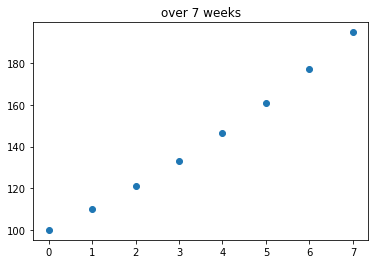

In [3]:
# over 7 weeks
weeks = np.arange(8)
Covid = 100*np.ones(8)
plt.figure(figsize=(6,4))
for i in range(1,8):
    Covid[i] = 1.1*Covid[i-1]
plt.scatter(weeks, Covid)
plt.title('over 7 weeks');

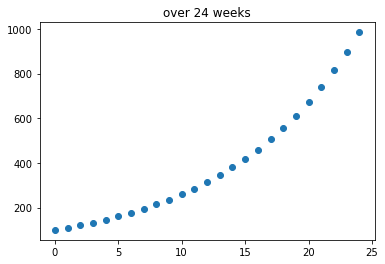

In [4]:
# over 24 weeks
weeks = np.arange(25)
Covid = 100*np.ones(25)
plt.figure(figsize=(6,4))
for i in range(1,25):
    Covid[i] = 1.1*Covid[i-1]     # 10% per week
plt.scatter(weeks, Covid)
plt.title('over 24 weeks'); 

but if you want to make it continuous, you need a special function $\Rightarrow \exp(t)$
$$C(t) = C_o exp(R't)$$
somehow, $\exp()$ acts like a *continuous* exponent. 

That's why it is sometimes noted $$e^{R't} = \exp(R't)$$

$R'$ is such that $exp(R't)$ when $t=1$ is 1.1
$$R' = \log(1.1) = 0.0953$$
$\log$ is the *reciprocal* function of $\exp$,

i.e. if $A=\exp(a)\;$ then $\; a = \log(A)$

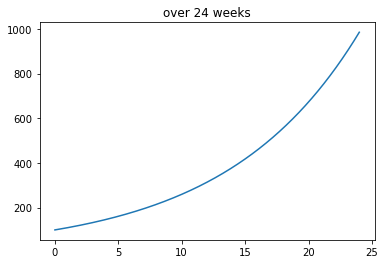

In [5]:
# continuous evolution over 24 weeks
time = np.linspace(0,24,1000)      # from 0 to 25 in 1000 points
Rprime = np.log(1.1)
Co = 100
Covid = Co * np.exp(Rprime*time)   # Covid = Co exp(R't)
plt.figure(figsize=(6,4))
plt.plot(time, Covid)
plt.title('over 24 weeks');

## with a R<0

R' = -0.1


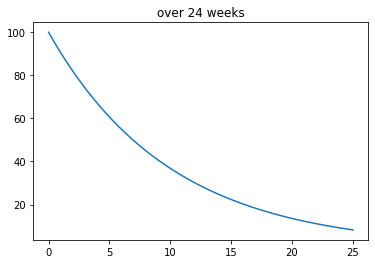

In [6]:
# continuous evolution over 24 weeks with
time = np.linspace(0,25,1000)     # from 0 to 25 in 1000 points
Rprime = -0.1 #np.log(0.9)
print("R' =", Rprime)
Co = 100
Covid = Co * np.exp(Rprime*time)  # Covid = Co exp(R't)
plt.figure(figsize=(6,4))
plt.plot(time, Covid)
plt.title('over 24 weeks');

and R = 0 means no evolution

## multiplicative rules
the $\exp()$ is similar to a continuous exponent and follows the same rules than exponents:
\begin{equation}\exp(a + b) = \exp(a)\exp(b)\end{equation}
$$\exp(2a) = \exp(a)^2$$
$$\exp(n a) = \exp(a)^n$$


In [7]:
def drawaxes():
    plt.plot([-3,3],[0,0],':k') # the real axis
    plt.plot([0,0],[-3,3],':k') # the imaginary axis
    plt.scatter([1,0,-1,0],[0,1,0,-1])
    plt.text(1,0.15,'1')
    plt.text(-1,0.15,'-1')
    plt.text(0.15,1,'j')
    plt.text(0.15,-1,'-j')
    plt.title('the complex plane $\mathbb{C}$')
def drawcpx(z, name='z'):
    plt.scatter(z.real, z.imag)
    plt.plot([0,z.real],[0,z.imag],'--k')
    plt.text(1.05*z.real, 1.05*z.imag,'%s = %s'%(name,str(z)[1:-1]));

## complex numbers
A very smart method to handle 2D values. *Check [github.com/delsuc/Fourier_Transform/complex_reminder.ipynb](https://github.com/delsuc/Fourier_Transform/blob/master/complex_reminder.ipynb) .*

- $\Rightarrow$ two values ($x$ & $y$) to store, noted along two axes $1$ *(real part)* and $j$ *(imaginary part)*
- space called $\mathbb{C}$
- a position in the plane determines a point, but also a **length** and an **angle** 


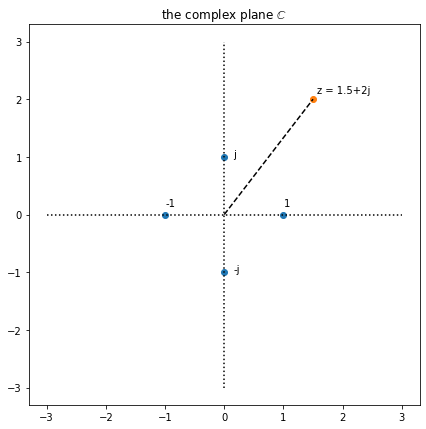

In [8]:
# let's draw this using 2 little utilities defined in background()
plt.figure(figsize=(7,7))
drawaxes()
z = 1.5 + 2j
drawcpx(z)

## you can do addition, and multiplication
- addition of complexes is adding both real and imaginary part. $\equiv$ to adding vectors.
    - No big deal
- multiplication of complexes is  multiplying **lengths** (people say  "modulus") and adding **angles**


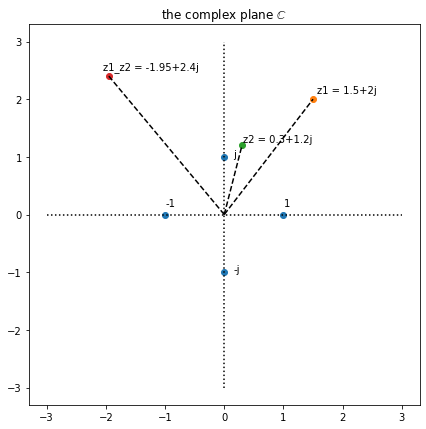

In [9]:
# let's draw this
plt.figure(figsize=(7,7))
drawaxes()
z1 = 1.5 +2j
z2 = 0.3 + 1.2j
z1_z2 = z1*z2 
for nz in ('z1','z2','z1_z2'):
    drawcpx(eval(nz), name=nz)

- so multiplication by complexes of modulus $1$ *(on the unity circle)* 
  is like a pure rotation by the angle of this complex number

## Quiz
- what is the angle of the rotation when
    - multiplying by $-1$
    - multiplying by $j$
    - multiplying by $-j$
    - multiplying by $\frac{1+j}{\sqrt{2}}$

## Quiz - solution
- what is the angle of the rotation when
    - multiplying by $-1$ $\quad$ 180°
    - multiplying by $j$ $\quad$ 90°
    - multiplying by $-j$ $\quad$ -90°
    - multiplying by $\frac{1+j}{\sqrt{2}}$  $\quad$ 45°
    - etc.

## complex exponential
Those multiplicative and additive rules fit perfectly the exponential we described earlier.

$\Rightarrow$ let's define the exponential of a complex number:<br>
$\exp(z) = exp(R)exp(j\theta) = R'\exp(j \theta) = R'e^{j \theta} \quad$ (modulus $R'$ and angle $\theta$)

So if we have:
$z_1 = R'_1e^{j \theta_1} \quad$ and $z_2 =  R'_2e^{j \theta_2} \quad$
then 
\begin{equation}z_1 \times z_2 =  R'_1 R'_2 e^{j (\theta_1+\theta_2)}\end{equation}
just following the rules for the exponential:

$\Rightarrow$ multiplying **lengths** and adding **angles**

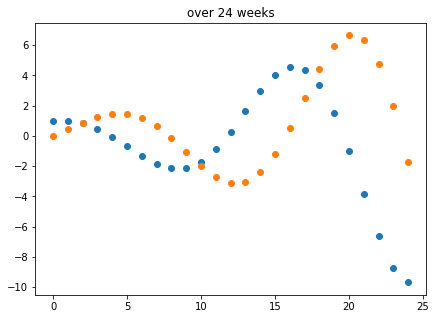

In [10]:
# let's draw this over 24 weeks
weeks = np.arange(25)
Covid = 1*np.ones(25) +0j
for i in range(1,25):
    Z = 1.1*np.exp(0.4j)       # angle of 0.7 radian, modulus of 1.1
    Covid[i] = Z*Covid[i-1]    # Z % per week
plt.figure(figsize=(7,5))
plt.scatter(weeks, Covid.real)
plt.scatter(weeks, Covid.imag)
plt.title('over 24 weeks'); 

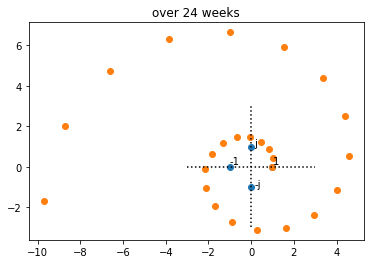

In [11]:
# let's draw this over 24 weeks
weeks = np.arange(25)
Covid = 1*np.ones(25) +0j
drawaxes()
for i in range(1,25):
    Z = 1.1*np.exp(0.4j)       # angle of 0.7 radian, modulus of 1.1
    Covid[i] = Z*Covid[i-1]    # Z % per week
plt.scatter(Covid.real, Covid.imag)
plt.title('over 24 weeks'); 

## with R<0

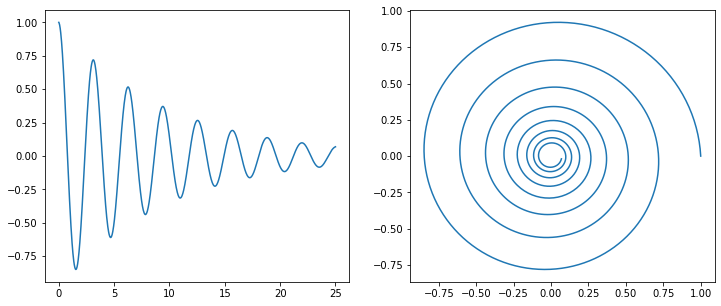

In [12]:
# continuous evolution over 24 weeks
time = np.linspace(0,25,1000)  # from 0 to 25 in 1000 points
Rprime = np.log(0.9)+2j        # angle of 2 radian, modulus of 0.9
Co = 1
Covid = Co * np.exp(Rprime*time)
fig, (axis1, axis2) = plt.subplots(ncols=2, figsize=(12,5))
axis1.plot(time, Covid.real)
axis2.plot(Covid.real, Covid.imag);

a damped sinusoid ! $\Rightarrow$ not so different from a FTICR signal !!!

## modeling of a "harmonic" signal
- one line, decay at rate $R$ (negative) and rotation at speed $\theta$:

\begin{equation}S(t) = A \exp(Rt) \exp(j \theta t)\end{equation}

- if regularly sampled at time $t_n = n\Delta t$, it becomes

$$ S_n = A \exp(nR \Delta t) \exp(n j \theta \Delta t) = A \exp(R \Delta t + j \theta \Delta t)^n = A Z^n$$
with $Z = \exp(R \Delta t + j \theta \Delta t)$

- in other words, we have a regression form: 
\begin{equation} S_{n} = Z S_{n-1} \\
S_o = A
\end{equation}
$A$ is the amplitude of the signal *(can be complex $\Rightarrow$ phase )*<br>
$Z$ is the characteristic pole of this "harmonic" signal


## extended to more than one line:

for $K$ different lines, with intensities $A_k$ and "poles" $Z_k$ we have:

\begin{equation}S_n = W_1 S_{n-1} +  W_2 S_{n-2} +  W_3 S_{n-3} \cdots  W_K S_{n-K}\end{equation}

where the $W_k$ uniquely depend on the $Z_k$ *(in a complicated way)*<br>
and $[S_1 \cdots S_K]$ depend on the $A_k$ 

Here eq(5) represents the **Autoregressive model (AR)** of this harmonic signal 
<br>
*(aka **Linear Prediction** model )*

## Hankel matrix and the AutoRegressive model
eq(4) can be written for any points of the sampled signal (except the $K$ first points)

we write the following $M \times (N-M)$ matrix $\mathbf{H}\quad H_{i,j} = S_{i+j-1}$:

\begin{equation}
\mathbf{H} = \begin{vmatrix}
S_1 & S_{2} & S_{3} & \cdots & S_{N-M} \\
S_{2} & S_{3} & S_{4} & \cdots & S_{N-M+1} \\
S_{3} & S_{4} & S_{5} & \cdots & S_{N-M+2} \\
\vdots  & & & \ddots & \\
S_M & S_{M+1} & S_{M+2} & \cdots & S_{N} \\
\end{vmatrix}
\end{equation}

$\mathbf{H}$ is a **Hankel** matrix. &nbsp; *(Toeplitz matrices tell a miror image story)*<br>
Because of AR, the rank of $\mathbf{H}$ is $K$ *(in a noise free system)*

Note how $S_n$ with $n : [1 \cdots N]$: runs on the edge of $\mathbf{H}$

## circulant matrices

$\mathbf{H}$ is a circulant matrix  &nbsp; ( *circulating* a single vector)

Multiplication with such a matrix $\;\equiv\;$ Convolution with the generating vector.

Convolution can be performed efficiently with Fast Fourier Transform (FFT)

Computation time $O(N^2) \rightarrow O( N \log N )$

*if 1k takes 1 msec for both, 1M will take 10sec instead of 16min*

In [15]:
1E6/1000/60, 10*1000

(16.666666666666668, 10000)

## and limitations

# urQRd, SANE and more  15 min

# Noise reduction - Cadzow's method (1988)

From a signal $S$ we can build a $M \times (N-M)$ matrix $\mathbf{H}\quad$
If *noise-free* $\;\textrm{rank}(\mathbf{H}) = K\quad$

but usually there is noise, so rank is not limited anymore

**Cadzow** approach$^1$ is 
- from $S$ compute $\mathbf{H}$ 
- extract the **SVD** of $\mathbf{H}$ &nbsp; *(slow - memory hungry)*
- truncate **SVD** to $K$  &nbsp; *(if $K$ signals are expected)*
- from truncation, rebuild $\mathbf{H}$ then $S$
- iterate

Very efficient (used in many techniques)<br>
**BUT** this is *slooow* and unrealistic for large $S \quad (N>10.000)$

<small>1. Cadzow JA *IEEE Trans. ASSP* **36** p49-62 (1988)</small>

## Noise reduction - urQRd$^1$ (2014)


Same as Cadzow, *but*...
- Truncate $\mathbf{H}$ first, thanks to *random projection* theorem
- use **QR** to estimate **SVD** from truncated $\mathbf{H}$ &nbsp; *(fast)*
- from **QR** decomposition, rebuild $\mathbf{H}$ then $S$
- iterate

plus...
- use FFT trick to compute all matrix products &nbsp; *(reduces the memory burden)*


<small>1.Chiron L., van Agthoven M. A., Kieffer B., Rolando C., Delsuc M-A. *Proc Natl Acad Sci USA*, **111** (4) :1385–1390, (2014)</small>

## Noise reduction - urQRd$^1$ (2014)


Same as Cadzow, *but*...
- Truncate $\mathbf{H}$ first, thanks to *random projection* theorem
&nbsp;  u<span style="color:red">r</span>QRd
- use **QR** to estimate **SVD** from truncated $\mathbf{H}$
&nbsp; &nbsp;  ur<span style="color:red">QR</span>d
- from **QR** decomposition, rebuild $\mathbf{H}$ then $S$
&nbsp; &nbsp;  urQR<span style="color:red">d</span>
- iterate

plus...
- use FFT trick to compute all matrix products.
&nbsp; &nbsp;  <span style="color:red">u</span>rQRd


<small>1.Chiron L., van Agthoven M. A., Kieffer B., Rolando C., Delsuc M-A. *Proc Natl Acad Sci USA*, **111** (4) :1385–1390, (2014)</small>




H (M x N_M) O (N-M K) = H' (M x K)
tH' = Q (K K) R (K M) 
Q Q* H = H" 

## urQRd - speed and robustness compared to Cadzow
on a synthetic dataset

![on a synthetic dataset](compo.png)



## urQRd - speed and robustness compared to Cadzow
![on a synthetic dataset](speed.png)

- less memory burden
- theoretical processing time in  $KN\log N \quad$ with $\quad K \ll M < N$

## SANE - choosing a better basis
**Quiz!** &nbsp;  *find the differences*
![](algo_big.png)

## SANE - choosing a better basis
![](algo_zoom.png)

## SANE vs urQRd

same test on 50 lines.
![](rank_compare.png)

## Synthetic dataset with 20 lines

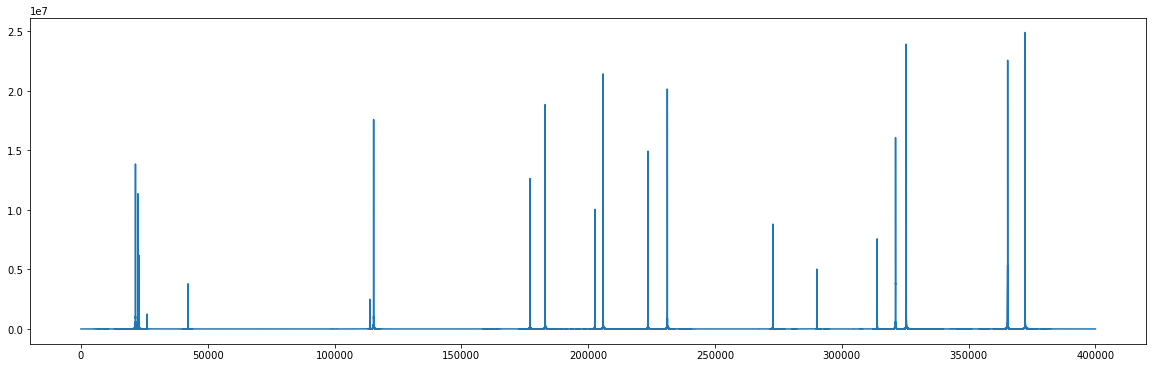

In [28]:
import figure_sup2 as s2
from urQRd import urQRd
from sane import sane
from figure_sup2 import mfft, gene, SNR
data,data0 = gene(lendata=100000, noise=300, noisetype='additive')
fig, ax = plt.subplots(figsize=(20,6))
plt.plot( mfft(data0) );
display(Markdown('## Synthetic dataset with 20 lines'))

## *SANE* vs urQRd

ADDITIVE noise (typically in 1D and along F2 in 2D)

In [29]:
def compare(noisy, clean):
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20,10))
    fig.subplots_adjust(hspace=0)
    ax[0].plot( mfft(noisy) )  
    ax[1].plot( mfft(clean) )
    ax[0].set_xbound((18000,45000))
    for i in (0,1):
        ax[i].set_ylim(ymax=1.6E7)

<big>**urQRd** Gain 14.0 dB</big>

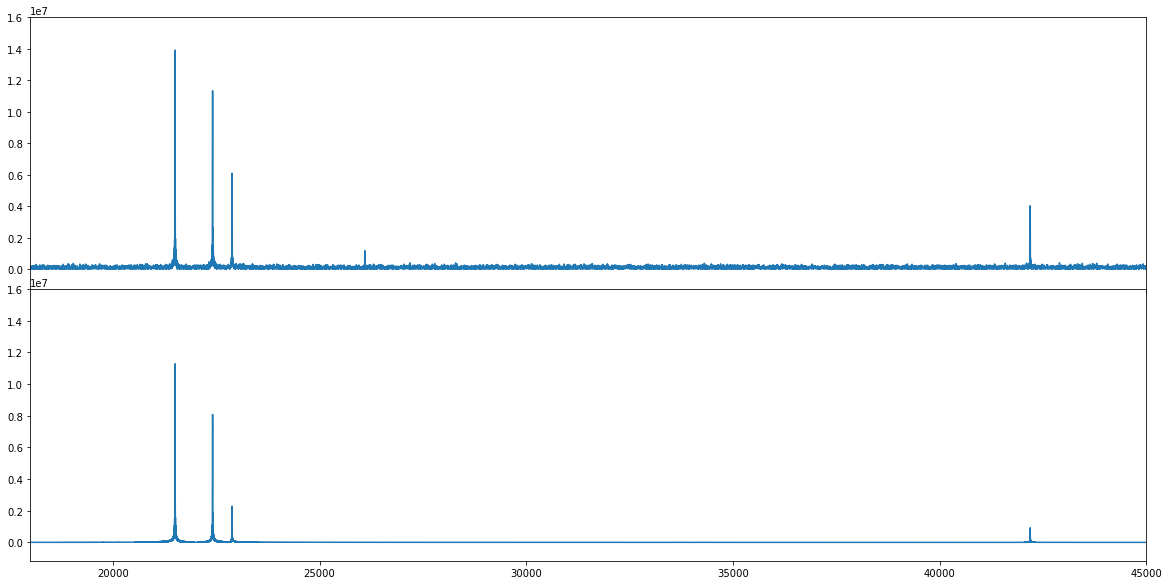

In [31]:
data_urqrd = urQRd(data, k=40, orda=15000, iterations=2) # denoise signal with rQRd
compare(data, data_urqrd) # defines in the background
display(Markdown('<big>**urQRd** Gain %.1f dB</big>'%SNR(data_urqrd,data0)))

## SANE vs *urQRd*

ADDITIVE noise (typically in 1D and along F2 in 2D)

<big>**SANE** Gain 29.4 dB</big>

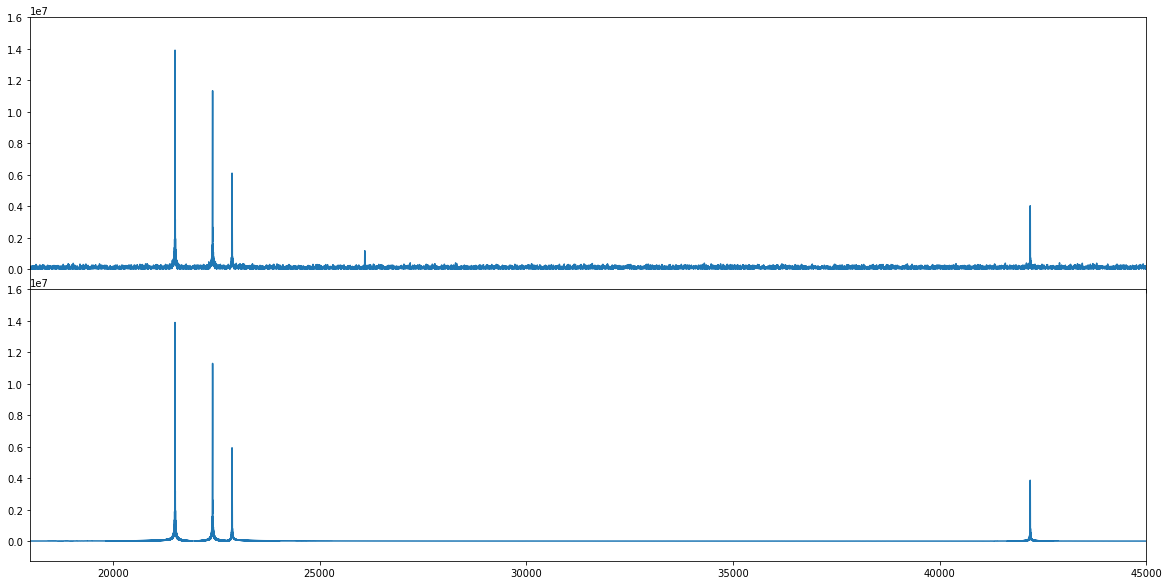

In [32]:
data_sane = sane(data, k=24, orda=15000, iterations=2) # denoise signal with rQRd
compare(data, data_sane)
display(Markdown('<big>**SANE** Gain %.1f dB</big>'%SNR(data_sane,data0)))

## *SANE* vs urQRd
MULTIPLICATIVE noise (typically along F1 in 2D)

<big>**urQRd** Gain 12.7 dB</big>

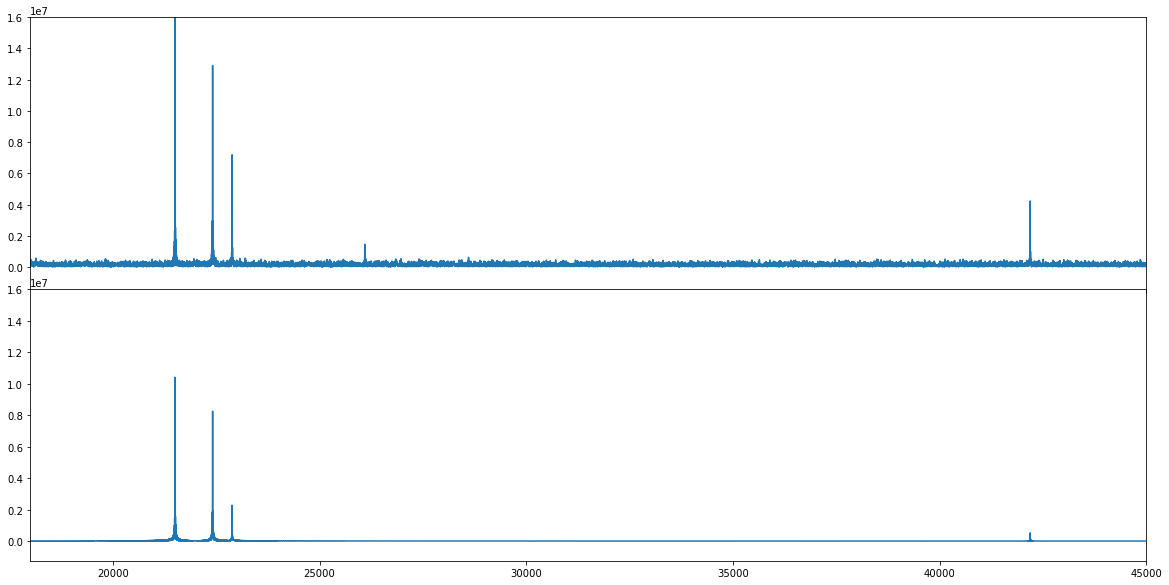

In [33]:
data,data0 = gene(lendata=100000, noise=200, noisetype='scintillation')
data_urqrd = urQRd(data, k=40, orda=15000, iterations=2) # denoise signal with rQRd
compare(data, data_urqrd)
display(Markdown('<big>**urQRd** Gain %.1f dB</big>'%SNR(data_urqrd,data0)))

## SANE vs *urQRd*

MULTIPLICATIVE noise (typically along F1 in 2D)

<big>**SANE** Gain 15.1 dB</big>

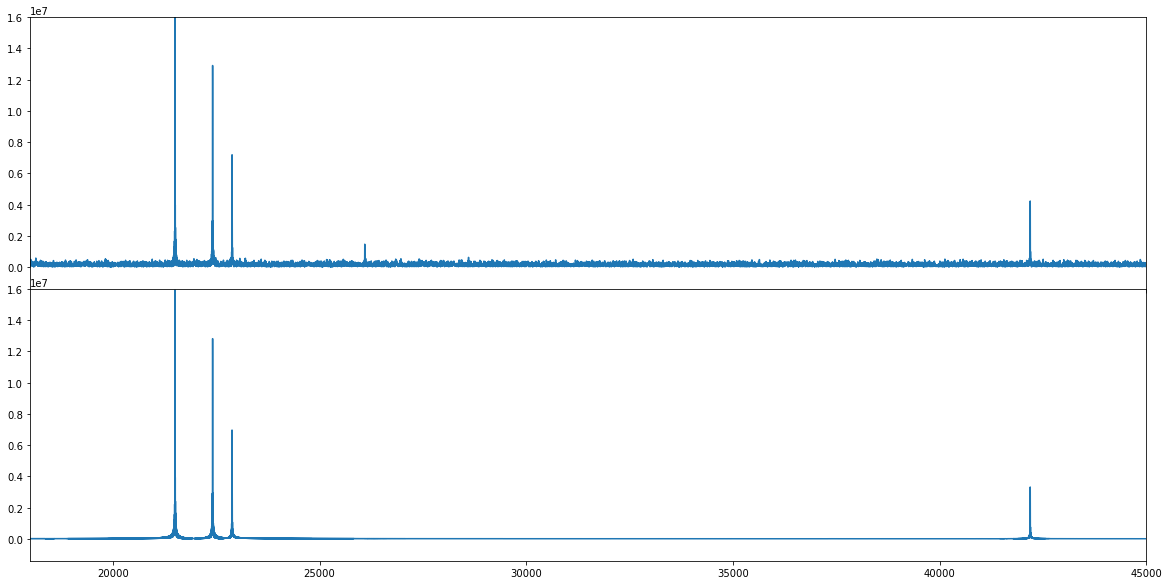

In [34]:
data_sane = sane(data, k=24, orda=15000, iterations=2) # denoise signal with rQRd
compare(data, data_sane)
display(Markdown('<big>**SANE** Gain %.1f dB</big>'%SNR(data_sane,data0)))

## SANE vs *urQRd*
using a larger $K$ on a proposition from Peter:

<big>**SANE** Gain 14.9 dB</big>

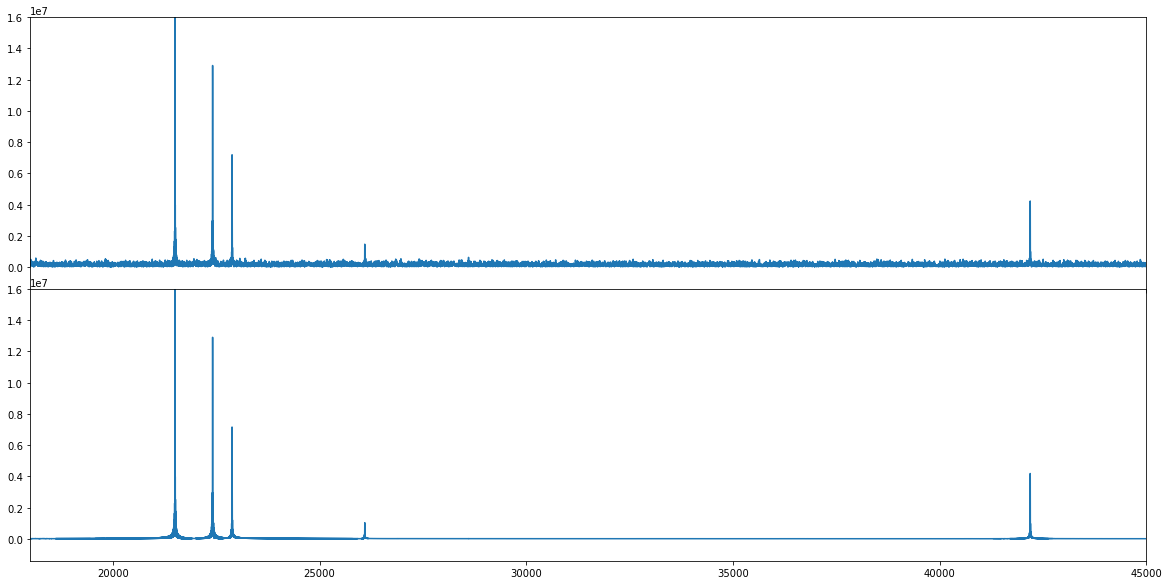

In [35]:
data_sane = sane(data, k=100, orda=15000, iterations=2) # denoise signal with rQRd
compare(data, data_sane)
display(Markdown('<big>**SANE** Gain %.1f dB</big>'%SNR(data_sane,data0)))

notice how the noise rejection is *officially* not as good (lower gain in dB), the small peaks is beter recovered

also, it is 100/24 times slower

## example in FT-ICR
![](sp1D.png)

## example in 1D ss-NMR
![](fig-ssnmr.png)

## in 2D ¹H NMR
![](fig_noesy.png)

thanks to the symmetry, the weak peaks recovered under the $t_1$-noise are validated

## in Non Uniform Sampling...
#### *it is another story*<br>
from C.Rolando presentation
![](NUS-CR.png)
<small>Nonuniform Sampling Acquisition of Two-Dimensional Fourier Transform Ion Cyclotron Resonance Mass Spectrometry for Increased Mass Resolution of Tandem Mass Spectrometry Precursor Ions.<br>
Bray F., Bouclon J., Chiron L., Witt M., Delsuc M-A., Rolando C.
(2017) *Anal Chem* 10.1021/acs.analchem.7b01850</small>

# concepts in 2D  5 min

# Narrow Band 2D
### what drives resolution in FTICR ?

$$R = \frac{m/z}{\Delta m/z} = \frac{\Delta f}{f} \qquad m/z \propto \frac{B_o}{f}$$

so $R \nearrow\:$ whenever $\Delta f \nearrow \quad$ 
and $\Delta f = \frac 1 2 T_{max}\:\:$ does not depends on sampling nor on $f$.

But large $T_{max}$ requires

- many data-points at constant Spectral BandWidth 

**or**

- reduced BandWidth at constant number of data-points



**or**

- Non Uniform Sampling $\rightarrow$ *another story*

## difference between F1 and F2
#### in F2 *(classical axis)*
reducing Bandwidth "zooms" into the spectrum - because of filters

In [36]:
def F2_BW():
    "show the effect of reduced BandWidth on a classical axis"
    D = mfft(data0)
    fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(16,8))
    fig.subplots_adjust(hspace=0)
    ax[0].plot(D)
    for i in range(1,3):
        xm = 50000*i
        xM = len(D)-xm
        for j in range(i+1):
            ax[j].plot([xm,xm],[0,2.5E7],'k:')
            ax[j].plot([xM,xM],[0,2.5E7],'k:')
        D[0:xm] = np.nan
        D[xM:] = np.nan
        ax[i].plot(D)

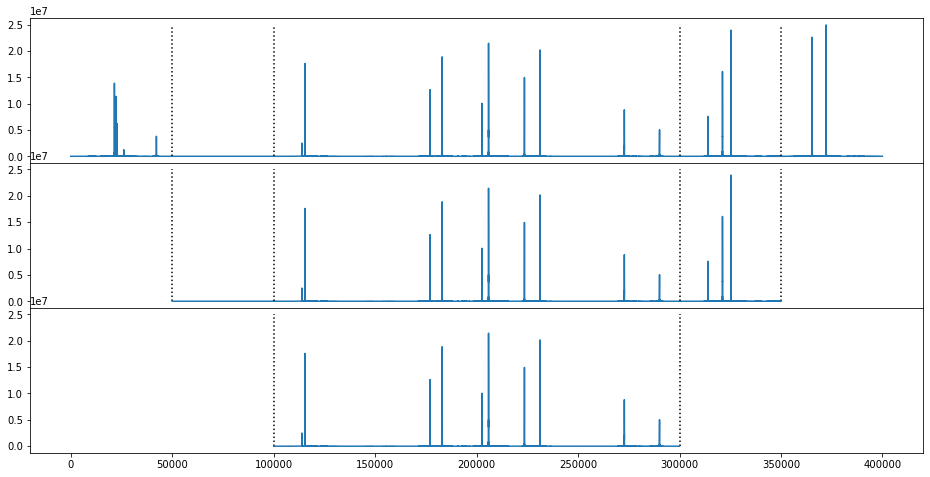

In [37]:
F2_BW()

In [38]:
def F1_BW():
    "show the effect of reduced BandWidth on a non-classical axis"
    D = mfft(data0)
    N = len(D)
    fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(16,8))
    fig.subplots_adjust(hspace=0)
    ax[0].plot(D)
    for i in range(1,3):
        DBW = np.zeros_like(D)
        xm = 50000*i
        xM = len(D)-xm
        for j in range(i+1):
            ax[j].plot([xm,xm],[0,2.5E7],'k:')
            ax[j].plot([xM,xM],[0,2.5E7],'k:')
        DBW[xm:xM] = D[xm:xM]
        DBW[xm:2*xm] += D[xm:0:-1]
        DBW[-2*xm:-xm] += D[-1:-xm-1:-1]
        DBW[0:xm] = np.nan
        DBW[xM:] = np.nan
        ax[i].plot(DBW)

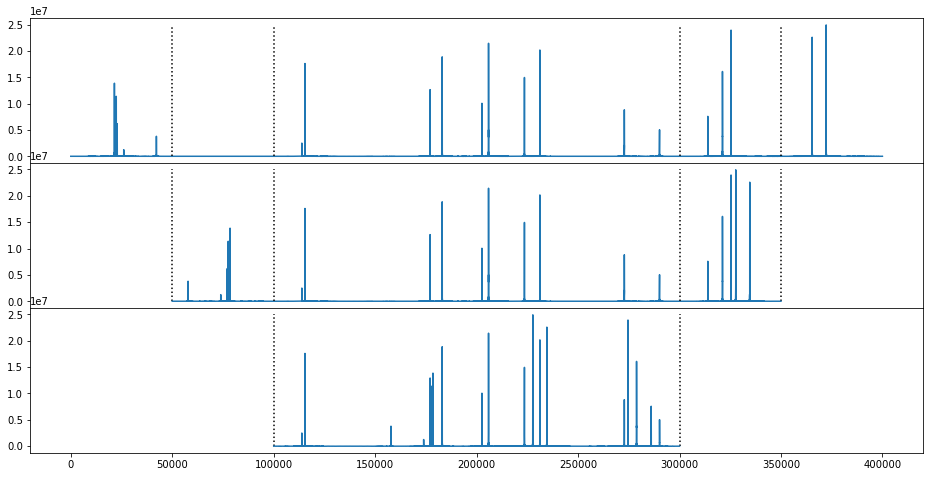

In [39]:
F1_BW()

# example on histones peptides¹
![](NB2.png)

<small>1.Narrowband modulation two-dimensional mass spectrometry and label-free relative quantification of histone peptides<br>
Halper M., Delsuc M-A., Breuker K., van Agthoven M. A.
(2020) *Anal Chem* 10.1021/acs.analchem.0c02843</small>

## effect of folding in F1
![](NB1.png)

## effect of folding in F1
![](NB3.png)

## effect of folding in F1
![](NB4.png)

## effect of folding in F1
![](NB1D.png)

# some more mathematics   10 min
- amplitude modulation and phase modulation
- phase in 2D
- hypercomplex numbers

# phase sensitive absorption 15 min
( results from this preprint: https://www.preprints.org/manuscript/202104.0445/v1 )
- phase in F2
- phase in F1
- results 

# Phase sensitive FTICR-MS
- in all the spectra we saw so-far, spectra were in modulus.
- however the Fourier Transform of the transien is complex *(a series of complex numbers)* 
- "*phasing*" a spectrum consists in rotating this numbers by a complex number of length 1.0: $e^{j \theta}$
    - $\theta$ can be constant over the spectrum: $0^{th}$ order phase
    - $\theta$ can be linearly varying over the spectrum: $1^{st}$ order phase
    - $\theta$ can be quadratically varying over the spectrum: $2^{nd}$ order phase

# Phase sensitive FTICR-MS
![](s4.png)
- The phase mix the absorption and dispersion linesphapes
- We see a strong linear dependence of phase (here a small spectral window)


## Phase sensitive FTICR-MS
![](s3.png)
linear phase correction in not enough

$\Rightarrow$ quadratic phase correction

## Phase sensitive FTICR-MS
interactive/automatic module for FTICR phasing in Spike (not finished yet, but soon)
![](s6.png)

## Phase sensitive FTICR-MS
![](s13-2.png)

## Phase sensitive FTICR-MS
![](PH1.png)
notice the baseline distortion

## Phase sensitive 2D FTICR-MS
( results from this preprint: https://www.preprints.org/manuscript/202104.0445/v1 )
![](PH2.png)
- F2 $\Rightarrow$ quadratic phase correction
- F1 $\Rightarrow$ linear phase correction


## Phasing rule of thumb
- global phase ($O^{th}$ order) is due to 
    - electronic delays 
    - computation
    - $\Rightarrow$ easy
- frequency linearly dependent phase ($1^{st}$ order) is due to
    - delay between pulse and acquisition
    - error on the position of $t=0$ origin of time 
    - $\Rightarrow$ doable
- frequency quadratically dependent phase ($2^{nd}$ order) is due to
    - frequency dependent delay between pulse and acquisition
    - frequency swept pulses
    - $\Rightarrow$ a pain

## *but there is more...* <small>*it took 15 years to NMR guys to realize that...*</small>

phases in F1 and in F2 are independent

you cannot do that in $\mathbb{C}$, we have "only" one phase, one $j$
 
$\Rightarrow$ have to go to hypercomplex algebra $\mathbb{H}$,
a 4 dimensionnal, commutative, non-invertible algebra.

\begin{equation}
z = a + ib + jc +kd \\
i^2 = -1 \quad j^2 = -1 \quad k^2 = 1 \\
ij = ji = k \quad ik = ki = -j \quad jk = kj = -i
\end{equation}

in $\mathbb{H}$ you can define independent phases: $e^{i \theta}$ and $e^{j \phi}$

and you can write (for a sub class of the element of $\mathbb{H}$) :
\begin{equation}
z = A e^{i \theta} e^{j \phi}
\end{equation}


## Phase sensitive 2D FTICR-MS
![](z00.png)

## Phase sensitive 2D FTICR-MS
![](PH3.png)

## Phase sensitive 2D FTICR-MS
![](PH4.png)

## Phase sensitive 2D FTICR-MS
folding also invert the sign of the signal.
![](PH5.png)
here $2 \omega$ harmonics are folded an odd number of times
$\Rightarrow$ separates them from the $1\omega$ signal

double the resolution

# conclusion
- resolution is paramount in MS
    - Narrow Band is a nice and simple trick to enhance it
    - harmonics is another (Bruker played it already)
    - Phasing is a nicer but not so simple trick to still enhance it
- we (you guys) still have to explore what to do with all this room !

- finally
    - know your exponentials 😊
    - and the rest
    - it's always more complex that you thought

- though it's doable  !

- I love python (did you notice ?)

# Thank you !